In [1]:
import numpy as np
import os, shutil
import cv2
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from torchvision import transforms as T

C:\Users\Andaman\AppData\Local\Temp\ipykernel_1692\1835756201.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Import Trained Models

In [2]:
def try_load_weight(model, model_name, checkpoint):
    weight_key = [key for key in list(checkpoint.keys()) if 'state_dict' in key and 'model' in key][0]
    try:
        print(f'Loading {model_name} weights...')
        model.load_state_dict(checkpoint[weight_key])
    except:
        print("My Model : Need DataParallel")
        model = nn.DataParallel(model)
        model.load_state_dict(checkpoint[weight_key], strict=True)
    print('==============================================================================')
    model = model.cuda()
    model = model.eval()

In [3]:
for model_type in os.listdir('results/'):
    print(f"==============={model_type}===============")
    for m in os.listdir(f"results/{model_type}"):
        print(m)

===============DoubleUNet===============
DoubleUNet_test
===============HP_tuned===============
CustomUNet_Tanh_LReLU
ResUNetMC-Adam-F9
ResUNetMC_Adam_LeakyReLU_F65
ResUNetMC_Adam_ReLU_F63
ResUNetMC_RMSprop_LeakyReLU_F33
ResUNetMC_RMSprop_LeakyReLU_F53
ResUNetMC_RMSprop_ReLU_F63
ResUNetMC_RMSprop_ReLU_F64
ResUNet_Adam_ReLU_F63
ResUNet_Adam_ReLU_F9
===============Model_Tuning===============
test001
test002
===============new_DICE===============
UNet-Adam-PReLU-32F
===============ResUNet===============
ResUNet-resnet18-64F
ResUNet-resnet18-baseline
ResUNet-resnet18-bs16
ResUNet-resnet18-bs32
ResUNet-resnet18-bs8
ResUNet-resnet34-baseline
===============ResUNetMultiConnection===============
ResUNetMC-baseline
sample_w_1-10
===============UNet===============
baseline
new_baseline
UNet-64F
UNet-PReLU-Cond-512P
UNet-PReLU-Cond-512P-64F
===============UNetMultiConnection===============
UNetMC
UNetMC-CondCrop-512P
UNetMC-PReLU-Cond-512P
UNetMC-ReLU-Cond-512P


In [4]:
import my_network.network as network
from my_network.UNetMultiConnection import UNetMultiConnection
from my_network.DoubleUNet import DoubleUNet
from my_network.UNet import UNet
from my_network.CustomUNet import CustomUNet
from my_network.ResUNet import ResUNet
from my_network.ResUNetMultiConnection import ResUNetMultiConnection
import torch
from torch import nn


num_img_ch = 1
num_classes = 2
num_features = 32

model_path_list = [
#                     'HP_tuned/ResUNet_Adam_ReLU_F63',
                    'HP_tuned/ResUNetMC_Adam_LeakyReLU_F65',
#                     'ResUNet/ResUNet-resnet18-64F',
#                     'ResUNet/ResUNet-resnet18-bs16',
#                     'ResUNet/ResUNet-resnet18-bs32',
#                     'ResUNet/ResUNet-resnet18-bs8',
#                    'ResUNetMultiConnection/ResUNetMC-baseline',
#                    'UNetMultiConnection/UNetMC-PReLU-Cond-512P',
#                    'UNet/UNet-PReLU-Cond-512P'
                  ]

checkpoint_list = [torch.load(f'results/{model_path}/model.pth', map_location='cuda') for model_path in model_path_list]


models_list = []
models_type_list = []
for i, model_path in enumerate(model_path_list):
    model_type = model_path.split('/')[0]
    
    if i == 0:
        model_type = 'ResUNetMultiConnection'

    
#     if model_type == 'UNet':
#         models_list.append(UNet(in_channels=checkpoint_list[i]['config'].num_img_ch,
#                                 out_channels=checkpoint_list[i]['config'].num_classes,
#                                 num_features=checkpoint_list[i]['config'].num_features))
    if model_type == 'CustomUNet':
        models_list.append(CustomUNet(in_channels =checkpoint_list[i]['config'].num_img_ch,
                                      out_channels=checkpoint_list[i]['config'].num_classes,
                                      num_features=checkpoint_list[i]['config'].num_features,
                                      activation=checkpoint_list[i]['config'].activation))
    elif model_type == 'UNetMultiConnection':
        models_list.append(UNetMultiConnection(in_channels=1,
                                               out_channels=2,
                                               num_features=32))
    elif model_type == 'DoubleUNet':
        models_list.append(DoubleUNet(in_channels=1, freeze_vgg=True))
    elif model_type == 'ResUNet':
        models_list.append(ResUNet(in_channels =checkpoint_list[i]['config'].num_img_ch,
                                   out_channels=checkpoint_list[i]['config'].num_classes,
                                   num_features=checkpoint_list[i]['config'].num_features,
                                   activation=checkpoint_list[i]['config'].activation,
                                   resnet_type=checkpoint_list[i]['config'].resnet_type,
                                   weight_path=checkpoint_list[i]['config'].weight_path))
    elif model_type =='ResUNetMultiConnection':
        models_list.append(ResUNetMultiConnection(in_channels =checkpoint_list[i]['config'].num_img_ch,
                                                  out_channels=checkpoint_list[i]['config'].num_classes,
                                                  num_features=checkpoint_list[i]['config'].num_features,
                                                  activation=checkpoint_list[i]['config'].activation))
    else:
        raise NotImplementedError(f"Model {model_type} is not implemented")
    
    try_load_weight(models_list[i], model_type, checkpoint_list[i])
    models_type_list.append(model_type)




# Load Baseline Model
baseline_checkpoint = torch.load('results/UNet/new_baseline/model.pth')
baseline_model = network.UNet(in_channels=baseline_checkpoint['config'].num_img_ch,
                              out_channels=baseline_checkpoint['config'].num_classes,
                              num_features=baseline_checkpoint['config'].num_features)
try:
    print(f'Loading Baseline UNet weights...')
    baseline_model.load_state_dict(baseline_checkpoint['model_UNet_state_dict'])
except:
    print("Baseline : Need DataParallel")
    baseline_model = nn.DataParallel(baseline_model)
    baseline_model.load_state_dict(baseline_checkpoint['model_UNet_state_dict'])
baseline_model.eval()
baseline_model.cuda()



print('Passed')
print('...')
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Baseline model has {count_parameters(baseline_model):,} trainable parameters')
for i, model in enumerate(models_list):
    print(f'Model {models_type_list[i]:30}: {count_parameters(model):10,} trainable parameters')

Loading ResUNetMultiConnection weights...
My Model : Need DataParallel
Loading Baseline UNet weights...
Baseline : Need DataParallel
Passed
...
Baseline model has 232,162 trainable parameters
Model ResUNetMultiConnection        : 12,489,482 trainable parameters


### Random Inference

C:\Users\Andaman\anaconda3\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\Andaman\anaconda3\lib\site-packages\torch\nn\functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


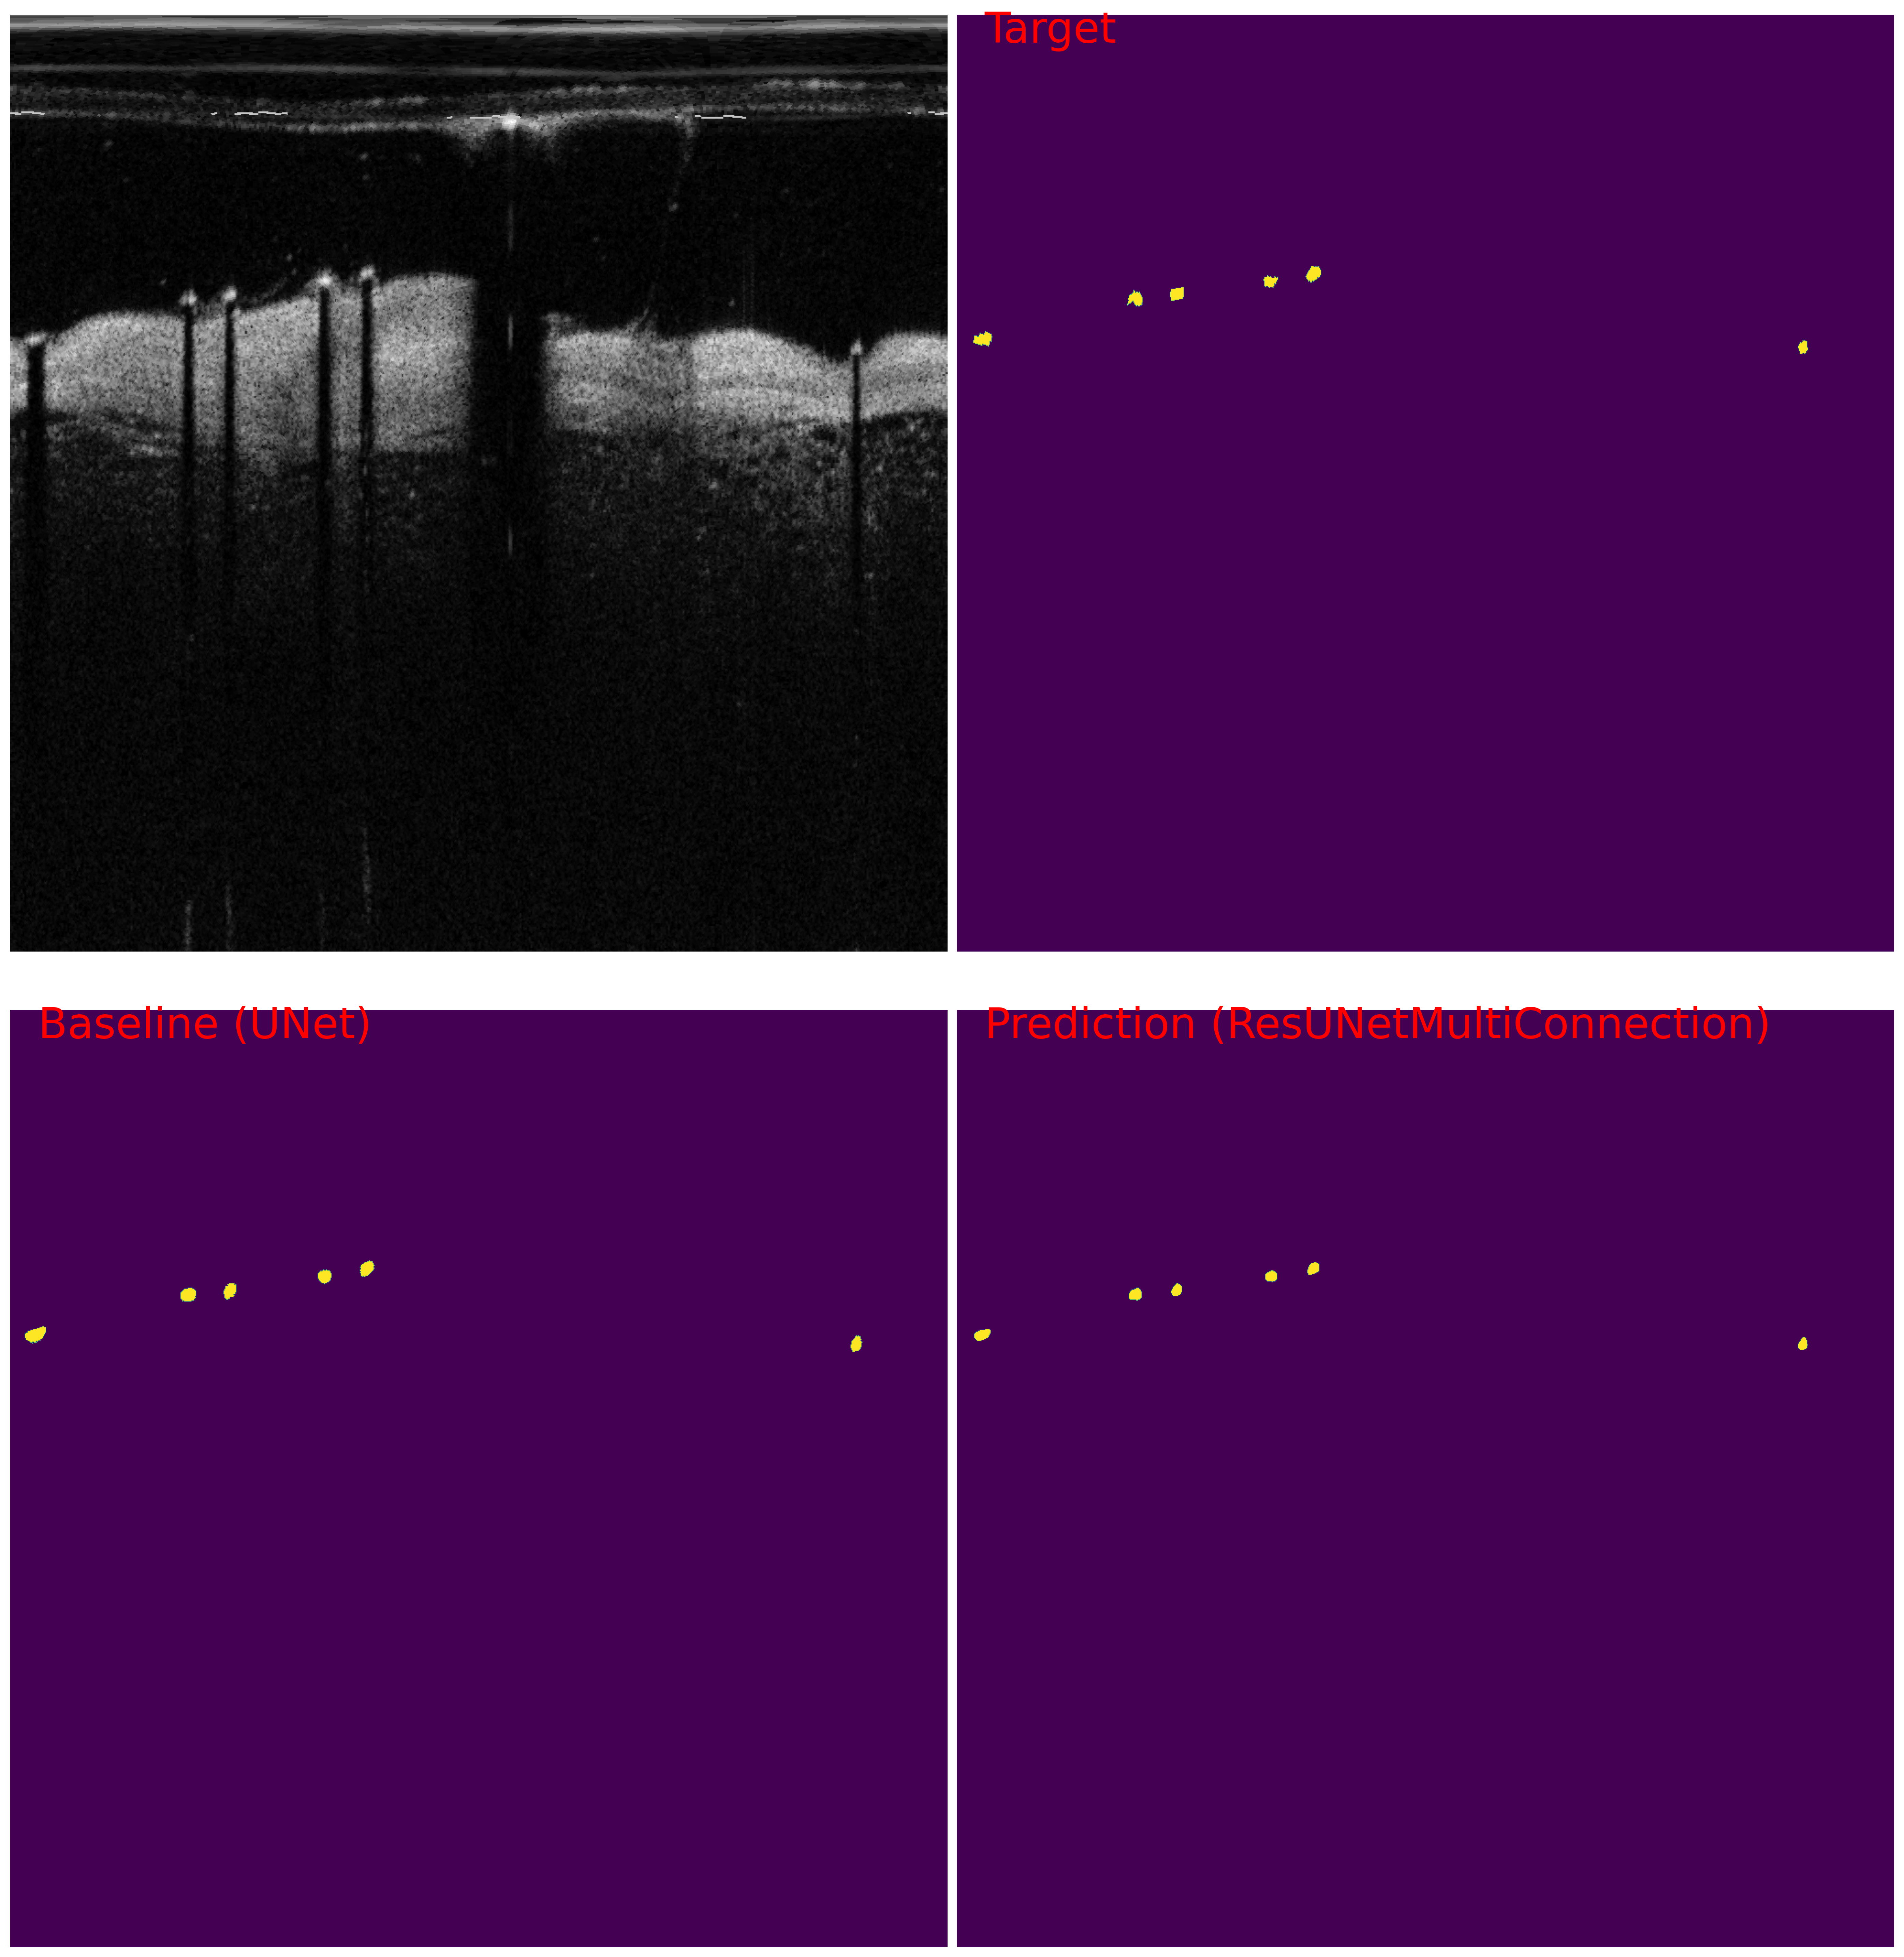

In [5]:
import random

my_model_number = 0
assert my_model_number < len(models_list), 'Wrong Index'

th = 0.5
image_list = sorted(os.listdir('polar_stent_dataset/image/test'))
image_name = random.choice(image_list)

image = Image.open(f'polar_stent_dataset/image/test/{image_name}')
image = np.array(image).astype(np.float32) / 255.0
image = image / np.std(image)
image = T.ToTensor()(np.array(image))

label = Image.open(f'polar_stent_dataset/label/test/{image_name}')
label = np.array(label).astype(np.float32) / 255.0
label = T.ToTensor()(np.array(label))

image = image.to('cuda')
baseline_output = baseline_model(image.unsqueeze(0))[0][1].detach().cpu().numpy()
output = models_list[0](image.unsqueeze(0))[0][1].detach().cpu().numpy()


fig, ax = plt.subplots(2,2,figsize=(20,20))
ax[0,0].imshow(image[0].detach().cpu().numpy(), cmap='gray')
ax[1,1].imshow(np.where(output > th, 1, 0),)
ax[1,0].imshow(np.where(baseline_output > th, 1, 0),)
ax[0,1].imshow(label[0].detach().cpu().numpy(),)
    
ax[1,1].text(30, 30,f'Prediction ({models_type_list[my_model_number]})', fontsize=30, color='red')
ax[1,0].text(30, 30,'Baseline (UNet)', fontsize=30, color='red')
ax[0,1].text(30, 30,'Target', fontsize=30, color='red')
    
fig.set_dpi(300)
fig.tight_layout()
fig.subplots_adjust(hspace=0.01, wspace=0.01)

for axis in ax.flatten():
    axis.axis('off')

plt.show()

# Calculate DICE Score

In [6]:
from metric import get_similiarity

In [7]:
image_list = sorted(os.listdir('polar_stent_dataset/image/test'))

raw_baseline_dice = []
th_baseline_dice = []

R = []
for i in range(len(models_list)):
    R.append(dict(model_type=model_path_list[i], 
                  dice_score=[],
                  th_dice_score=[]))

th = 0.5

for index, image_name in tqdm(enumerate(image_list), total=len(image_list)):
    
    image = Image.open(f'polar_stent_dataset/image/test/{image_name}')
    image = np.array(image).astype(np.float32) / 255.0
    image = image / np.std(image)
    image = T.ToTensor()(np.array(image))
    
    label = Image.open(f'polar_stent_dataset/label/test/{image_name}')
    label = np.array(label).astype(np.float32) / 255.0
    label = T.ToTensor()(np.array(label))
    
    image = image.to('cuda')
    baseline_output = baseline_model(image.unsqueeze(0))[0][1].detach().cpu()
    th_baseline_output = T.ToTensor()(np.where(baseline_output > th, 1, 0))
    
    for i, model in enumerate(models_list):
        
        output = model(image.unsqueeze(0))[0][1].detach().cpu()
        th_output = T.ToTensor()(np.where(output > th, 1, 0))
        
        R[i]['dice_score'].append(get_similiarity(output, label).item())
        R[i]['th_dice_score'].append(get_similiarity(th_output, label).item())
    
    raw_baseline_dice.append(get_similiarity(baseline_output, label).item())
    th_baseline_dice.append(get_similiarity(th_baseline_output, label).item())


print(f"Raw : Baseline DICE\t:{np.mean(raw_baseline_dice):.4f}")
print(f"TH  : Baseline DICE\t:{np.mean(th_baseline_dice):.4f}\n")

for result in R:
    print(f"Raw : {result['model_type']:45} DICE :{np.mean(result['dice_score']):.4f}")
    print(f"TH  : {result['model_type']:45} DICE :{np.mean(result['th_dice_score']):.4f}")

  0%|          | 0/152 [00:00<?, ?it/s]

C:\Users\Andaman\anaconda3\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\Andaman\anaconda3\lib\site-packages\torch\nn\functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


Raw : Baseline DICE	:0.5038
TH  : Baseline DICE	:0.6484

Raw : HP_tuned/ResUNetMC_Adam_LeakyReLU_F65         DICE :0.6326
TH  : HP_tuned/ResUNetMC_Adam_LeakyReLU_F65         DICE :0.7009


## Calculate PC/RC/F1 Score

In [5]:
from metric import calculate_precision_recall_f1

In [6]:
image_list = sorted(os.listdir('polar_stent_dataset/image/test'))

baseline_precision, baseline_recall, baseline_f1 = [], [], []

R = []
for i in range(len(models_list)):
    R.append(dict(model_type=model_path_list[i], 
                  precision=[],
                  recall=[],
                  f1=[]))

th_distance = 9.77 / 1.4421
th = 0.5

for index, image_name in tqdm(enumerate(image_list), total=len(image_list)):
    
    image = Image.open(f'polar_stent_dataset/image/test/{image_name}')
    image = np.array(image).astype(np.float32) / 255.0
    image = image / np.std(image)
    image = T.ToTensor()(np.array(image))
    
    label = Image.open(f'polar_stent_dataset/label/test/{image_name}')
    label = np.array(label)
    
    image = image.to('cuda')
    baseline_output = baseline_model(image.unsqueeze(0))[0][1].detach().cpu()
    baseline_output = np.where(baseline_output > th, 255, 0).astype(np.uint8)
    
    b_prec, b_rec, b_f1 = calculate_precision_recall_f1(baseline_output, label, threshold_distance=th_distance)
    baseline_precision += [b_prec]
    baseline_recall    += [b_rec]
    baseline_f1        += [b_f1]
    
    for i, model in enumerate(models_list):
        
        output = model(image.unsqueeze(0))[0][1].detach().cpu()
        output = np.where(output > th, 255, 0).astype(np.uint8)
        
        prec, rec, f1 = calculate_precision_recall_f1(output, label, threshold_distance=th_distance)
        
        R[i]['precision'] += [prec]
        R[i]['recall']    += [rec]
        R[i]['f1']        += [f1]
    

print('='*50)
print(f" Baseline  Precision :{np.mean(baseline_precision):.4f}")
print(f" Baseline  Recall :{np.mean(baseline_recall):.4f}")
print(f" Baseline  F1-Score :{np.mean(baseline_f1):.4f}")

for result in R:
    print(f"{result['model_type']:45} Precision :{np.mean(result['precision']):.4f}")
    print(f"{result['model_type']:45} Recall    :{np.mean(result['recall']):.4f}")
    print(f"{result['model_type']:45} F1-Score  :{np.mean(result['f1']):.4f}")
    
    
    

  0%|          | 0/152 [00:00<?, ?it/s]

C:\Users\Andaman\anaconda3\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(
C:\Users\Andaman\anaconda3\lib\site-packages\torch\nn\functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


 Baseline  Precision :0.8313
 Baseline  Recall :0.8963
 Baseline  F1-Score :0.8478
HP_tuned/ResUNetMC_Adam_LeakyReLU_F65         Precision :0.9199
HP_tuned/ResUNetMC_Adam_LeakyReLU_F65         Recall    :0.8928
HP_tuned/ResUNetMC_Adam_LeakyReLU_F65         F1-Score  :0.9021


## Error Analysis

In [13]:
from skimage.measure import regionprops, label

def plot_stent_pos(polar_image, threshold_distance=10):
    
    cart_image = cv2.linearPolar(polar_image.T, (512, 512), 484, cv2.WARP_INVERSE_MAP)

    # Clean outer background
    mask = np.zeros_like(cart_image)
    mask = cv2.circle(mask, (512, 512), 483, (255, 255, 255), -1)
    cart_image = cv2.bitwise_and(mask, cart_image)
    
    # Change to RGB
    cart_image = cv2.cvtColor(cart_image, cv2.COLOR_GRAY2RGB)

    pred_regions = regionprops(label(cart_image, connectivity=None))
    
    xs, ys = [], []

    for props in pred_regions:
        y0, x0 = props.centroid[0], props.centroid[1]
        xs += [x0]
        ys += [y0]
        cart_image = cv2.circle(cart_image, (int(x0), int(y0)), 1, (255,0,0), 5)    
    
    cart_image = cv2.circle(cart_image, (int(np.mean(xs)), int(np.mean(ys))), 1, (0,255,0), 3)    
    
    return cart_image, len(pred_regions)

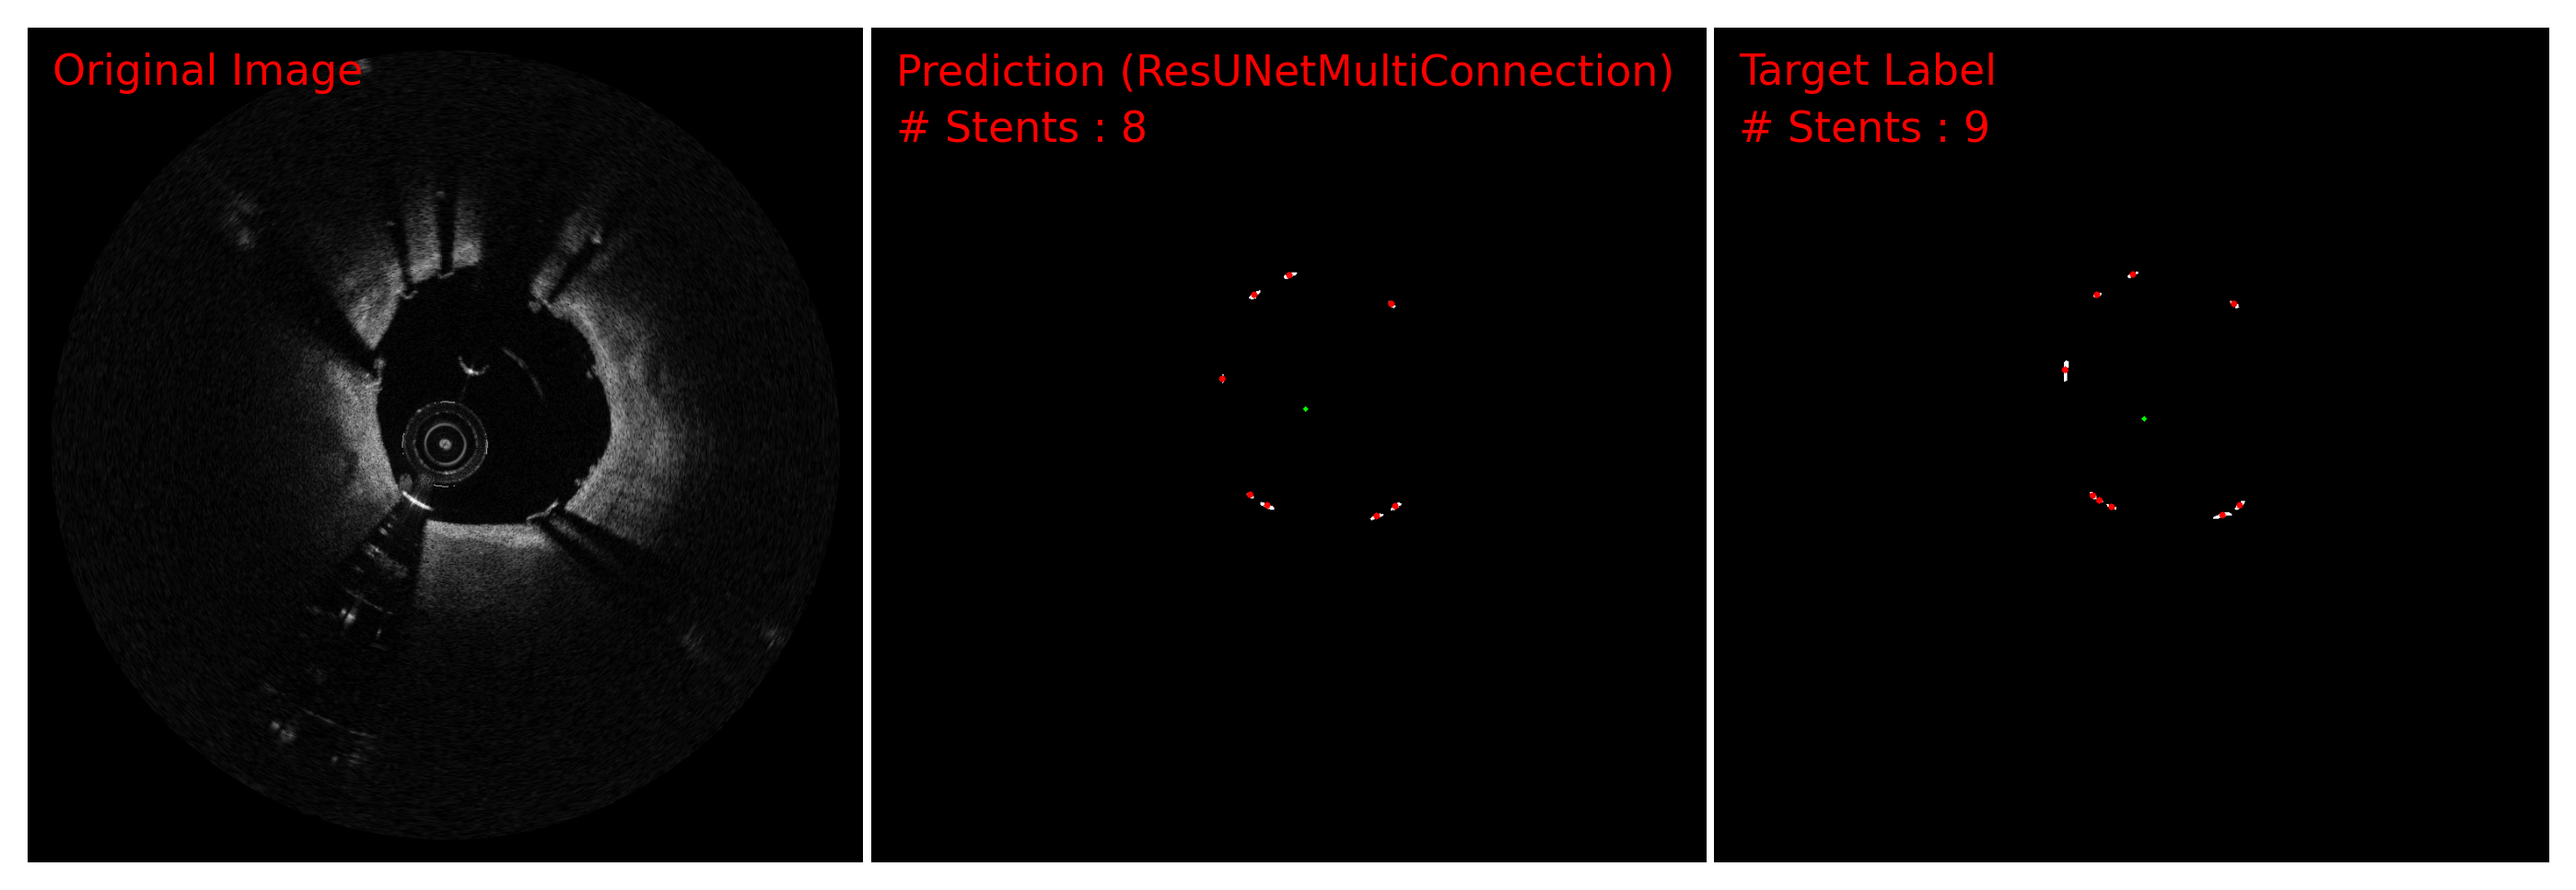

In [24]:
import random
th_distance = 9.77 / 1.4421

my_model_number = 0
assert my_model_number < len(models_list), 'Wrong Index'

th = 0.5
image_list = sorted(os.listdir('polar_stent_dataset/image/test'))
image_name = random.choice(image_list)

image = Image.open(f'polar_stent_dataset/image/test/{image_name}')
cart_original_image = cv2.linearPolar(np.array(image).T, (512, 512), 484, cv2.WARP_INVERSE_MAP)
image = np.array(image).astype(np.float32) / 255.0
image = image / np.std(image)
image = T.ToTensor()(np.array(image))

target = Image.open(f'polar_stent_dataset/label/test/{image_name}')
target = np.array(target).astype(np.uint8)

image = image.to('cuda')
baseline_output = baseline_model(image.unsqueeze(0))[0][1].detach().cpu().numpy()
output = models_list[0](image.unsqueeze(0))[0][1].detach().cpu().numpy()
output = np.where(output > 0.5, 255, 0).astype(np.uint8)

cart_output, num_pred = plot_stent_pos(output)
cart_target, num_target = plot_stent_pos(target)

fig, ax = plt.subplots(1,3,figsize=(10,20))

ax[0].imshow(cart_original_image, cmap='gray')
ax[1].imshow(cart_output)
ax[2].imshow(cart_target)

font_size = 11
ax[0].text(30, 70,f'Original Image', fontsize=font_size, color='red')
ax[1].text(30, 70,f'Prediction ({models_type_list[my_model_number]})', fontsize=font_size, color='red')
ax[2].text(30, 70,'Target Label', fontsize=font_size, color='red')
ax[1].text(30, 140,f'# Stents : {num_pred}', fontsize=font_size, color='red')
ax[2].text(30, 140,f'# Stents : {num_target}', fontsize=font_size, color='red')
    
fig.set_dpi(300)
fig.tight_layout()
fig.subplots_adjust(hspace=0.01, wspace=0.01)

for axis in ax.flatten():
    axis.axis('off')

plt.show()

In [ ]:
plt.figure(figsize=(10,10))

image_list = sorted(os.listdir('polar_stent_dataset/image/test'))
image_name = random.choice(image_list)

image = Image.open(f'polar_stent_dataset/image/test/{image_name}')
cart_original_image = cv2.linearPolar(np.array(image).T, (512, 512), 484, cv2.WARP_INVERSE_MAP)
# cart_original_image

mask = np.zeros_like(cart_original_image)
mask = cv2.circle(mask, (512, 512), 53, (255, 255, 255), -1)
mask = cv2.bitwise_not(mask)

new_image = cv2.bitwise_and(mask, cart_original_image)
new_image = np.where(new_image > 80, 255, 0)



plt.imshow(new_image, cmap='gray')

contours = measure.find_contours(new_image, 0.8)

In [ ]:
len(contours)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = new_image

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 100)

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(r, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [ ]:
plt.imshow(output)

# Appendix

In [ ]:
weight = torch.load('results/UNet/baseline/model.pth')

In [ ]:
weight['config']